# Using an AI Model to Classify Different Moles by Their Image

In this project we're going to be using machine learning to help us identify moles classifying them into benign or malign.

Approach / Wokflow:

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once we're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

The process of using a pretrained model and adapting it to your own problem is called transfer learning. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.

# Problem

Given an image of a mole, can we predict wheter it's a benign or maling mole?

# Data

The original data came from ISIC (The International Skin Imaging Collaboration​). The data consists of two folders with each 1800 pictures (224x244) of the two types of moles.

There is also a version of it available on Kaggle: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign/data

# Evaluation

If we can reach +80% accuracy at classifying moles in benign or malign, we'll pursue the project.

# Features

Not much specified about the features of the dataset but along this notebook we'll explore it.

# Getting tools ready

In [98]:
# Importing tools
import tensorflow as tf
import tensorflow_hub as hub

# Getting data ready

In [99]:
# Unzipping the data
# !unzip 'drive/My Drive/skin-cancer-detection/data/moles-2.zip' -d 'drive/MyDrive/skin-cancer-detection/data'

In [100]:
# Let's create datasets with images as array (dtype=unit8) and labels as strings. Then we'll create a test dataset and a train dataset with the images labeled, combined and shuffled.
# import tensorflow as tf (Already imported above)
import os

import tensorflow as tf
import os

# Define paths to the four directories
test_benign_dir = 'drive/MyDrive/skin-cancer-detection/data/test/benign'
test_malignant_dir = 'drive/MyDrive/skin-cancer-detection/data/test/malignant'
train_benign_dir = 'drive/MyDrive/skin-cancer-detection/data/train/benign'
train_malignant_dir = 'drive/MyDrive/skin-cancer-detection/data/train/malignant'

# Function to load an image, preprocess it and return the image array and label
def load_image(image_path, label):
    img = tf.io.read_file(image_path)  # Read the image file
    img = tf.image.decode_image(img, channels=3, dtype=tf.uint8)  # Decode the image as uint8
    img.set_shape([None, None, 3])  # Explicitly set the shape: height, width, 3 channels (RGB)
    # img = tf.image.resize(img, [224, 224])  # Images already sized (224x224). If not, we should run this line.
    return img, label

# Helper function to create a dataset for a given directory and label
def create_dataset(image_dir, label):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.jpg', '.png'))]
    labels = [label] * len(image_paths)  # Create a list of labels of the same length as the image_paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda path, label: load_image(path, label))
    return dataset

# Create datasets for test benign and malignant folders
test_benign_dataset = create_dataset(test_benign_dir, 'benign')
test_malignant_dataset = create_dataset(test_malignant_dir, 'malignant')

# Combine and shuffle test datasets
test_dataset = test_benign_dataset.concatenate(test_malignant_dataset)
test_dataset = test_dataset.shuffle(buffer_size=1000)  # Buffer size of 1000 (adjust as needed)

# Create datasets for train benign and malignant folders
train_benign_dataset = create_dataset(train_benign_dir, 'benign')
train_malignant_dataset = create_dataset(train_malignant_dir, 'malignant')

# Combine and shuffle train datasets
train_dataset = train_benign_dataset.concatenate(train_malignant_dataset)
train_dataset = train_dataset.shuffle(buffer_size=1000)  # Buffer size of 1000 (adjust as needed)

# Batch the datasets (optional, adjust batch size as needed)
test_dataset = test_dataset.batch(32)
train_dataset = train_dataset.batch(32)

# Prefetch to optimize performance
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Example: iterate over the test dataset
print("Test Dataset:")
for images, labels in test_dataset:
    print(images.shape)
    print(labels)

# Example: iterate over the train dataset
print("Train Dataset:")
for images, labels in train_dataset:
    print(images.shape)
    print(labels)  # Example output: ['benign', 'malignant', ...]


Test Dataset:
(32, 224, 224, 3)
tf.Tensor(
[b'benign' b'malignant' b'malignant' b'malignant' b'malignant' b'benign'
 b'benign' b'malignant' b'malignant' b'benign' b'benign' b'benign'
 b'malignant' b'malignant' b'malignant' b'malignant' b'benign' b'benign'
 b'malignant' b'benign' b'benign' b'malignant' b'benign' b'malignant'
 b'benign' b'benign' b'benign' b'malignant' b'malignant' b'malignant'
 b'benign' b'malignant'], shape=(32,), dtype=string)
(32, 224, 224, 3)
tf.Tensor(
[b'benign' b'malignant' b'benign' b'benign' b'benign' b'benign'
 b'malignant' b'benign' b'malignant' b'malignant' b'malignant' b'benign'
 b'benign' b'benign' b'malignant' b'benign' b'benign' b'malignant'
 b'malignant' b'benign' b'benign' b'benign' b'malignant' b'benign'
 b'benign' b'malignant' b'benign' b'malignant' b'malignant' b'benign'
 b'malignant' b'benign'], shape=(32,), dtype=string)
(32, 224, 224, 3)
tf.Tensor(
[b'malignant' b'malignant' b'malignant' b'malignant' b'malignant'
 b'benign' b'benign' b'malignant'

# Let's visualize what we've done

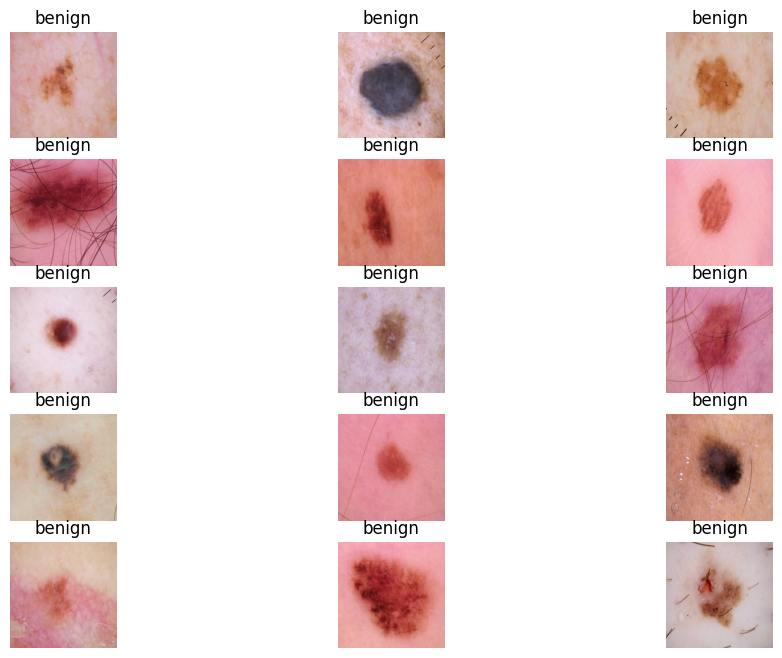

In [101]:
# Display first 15 images of moles, and how they are labeled
import matplotlib.pyplot as plt

# Function to display images in a grid with their labels
def display_images(dataset, num_images=15):
    # Create a figure
    plt.figure(figsize=(12, 8))

    for i, (images, labels) in enumerate(dataset.unbatch().take(num_images)):
        # Convert TensorFlow Tensors to NumPy arrays for display
        img = images.numpy().astype("uint8")
        label = labels.numpy().decode('utf-8')

        # Add subplot for each image
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

    # Show the plot
    plt.show()

# Call the function to display the first 15 images from the train dataset
display_images(train_dataset, num_images=15)


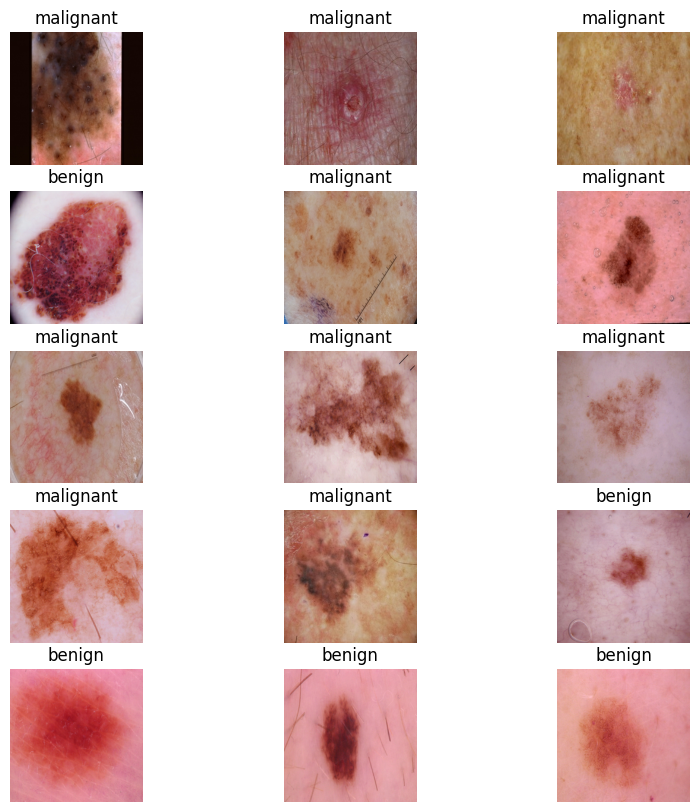

In [102]:
# Display 15 random images of moles, and how they are labeled
def display_random_images(dataset, num_images=15):
    # Shuffle the dataset before selecting images
    shuffled_dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the dataset with a buffer size of 1000

    # Create a figure
    plt.figure(figsize=(10, 10))

    for i, (images, labels) in enumerate(shuffled_dataset.unbatch().take(num_images)):
        # Convert TensorFlow Tensors to NumPy arrays for display
        img = images.numpy().astype("uint8")
        label = labels.numpy().decode('utf-8')

        # Add subplot for each image
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

    # Show the plot
    plt.show()

# Call the function to display 15 random images from the train dataset
display_random_images(train_dataset, num_images=15)


It looks like the first 15 images are all benign, let's check if the images were shufflede correctly

In [103]:
# Let's see if the last 15 labels from the dataset
def get_last_labels(dataset, num_labels=15):
    # Unbatch the dataset to get individual labels
    labels_list = []
    for images, labels in dataset.unbatch():
        labels_list.append(labels.numpy().decode('utf-8'))  # Collect all labels as a list

    # Get the last `num_labels` from the list
    return labels_list[-num_labels:]

# Get the labels of the last 15 images from the train dataset
last_15_labels = get_last_labels(train_dataset, num_labels=15)
print(last_15_labels)


['malignant', 'benign', 'malignant', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'benign', 'malignant', 'malignant', 'benign']


We can see that it was a conicidence, the data is indeed shuffled

# Data Exploration

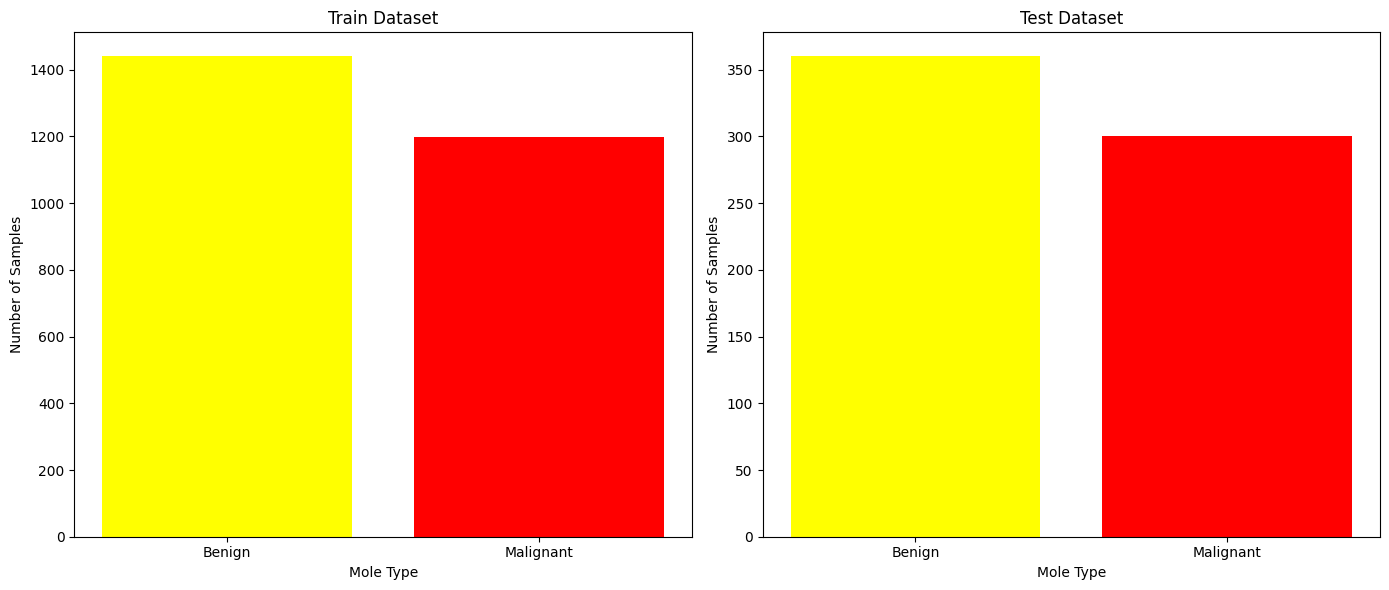

In [129]:
# Let's see how many benign and malignant samples do we have in each data set.
from collections import Counter

def count_labels(dataset):
    label_counter = Counter()  # Initializing a counter for the labels
    for _, labels in dataset.unbatch():  # Unbatching the dataset and count the labels
        label = labels.numpy().decode('utf-8')  # Decoding label from bytes to string
        label_counter[label] += 1
    return label_counter

# Counting the labels in train and test datasets
train_counts = count_labels(train_dataset)
test_counts = count_labels(test_dataset)

# Preparing data for plotting
labels = ['Benign', 'Malignant']
train_values = [train_counts['benign'], train_counts['malignant']]
test_values = [test_counts['benign'], test_counts['malignant']]

# Specifying colors for benign and malignant (yellow for benign, red for malignant)
colors = ['yellow', 'red']

# Creating two subplots
plt.figure(figsize=(14, 6))

# Training dataset plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.bar(labels, train_values, color=colors)
plt.title('Train Dataset')
plt.xlabel('Mole Type')
plt.ylabel('Number of Samples')

# Testing dataset plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.bar(labels, test_values, color=colors)
plt.title('Test Dataset')
plt.xlabel('Mole Type')
plt.ylabel('Number of Samples')

# Displaying the plots
plt.tight_layout()  # Adjusting layout to prevent overlap
plt.show()


# Modelling

We're going to use a simple model to save time and resources.

We first need to preprocess the data. Since the model that we are going to use from sklearn expects flat arrays (rather than 3D images).

In [135]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Preprocessing the data
def preprocess_data(dataset):
    images = []
    labels = []

    # Iterate through the dataset to collect images and labels
    for img, label in dataset.unbatch():
        img = img.numpy().flatten()  # Flatten the image to 1D
        label = label.numpy().decode('utf-8')  # Convert label from bytes to string
        images.append(img)
        labels.append(label)

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Encode labels (benign -> 0, malignant -> 1)
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    return images, labels

# Preprocess the training and validation data
X_train, y_train = preprocess_data(train_dataset)
X_val, y_val = preprocess_data(test_dataset)


In [136]:
# Initializing and fitting the model
model = SVC()
model.fit(X_train, y_train)

SVC()

# Testing and evaluating the model

In [137]:
# Predicting on the validation data
y_pred = model.predict(X_val)

In [138]:
# Evaluating the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 83.64%


# Model in action
We are going to make a prediction on a random image from the dataset and compare it with the true label.

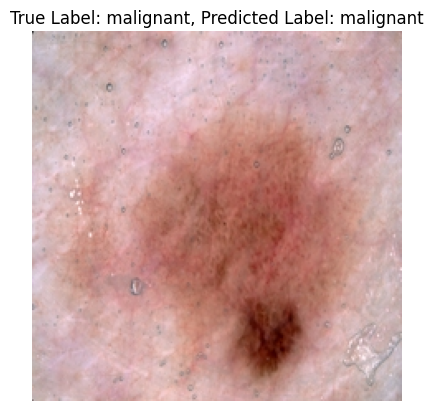

In [142]:
import random

def get_random_image_and_label(dataset):
    # Unbatching and converting the dataset to a list of (image, label) pairs
    images_and_labels = list(test_dataset.unbatch())

    # Selecting a random index
    random_index = random.randint(0, len(images_and_labels) - 1)

    # Getting the image and label at the random index
    image, label = images_and_labels[random_index]

    # Converting image to numpy array and flatten it
    image_flat = image.numpy().flatten()

    # Converting label to a string
    label_str = label.numpy().decode('utf-8')

    return image, image_flat, label_str

# Getting a random image from the validation dataset
image, image_flat, true_label = get_random_image_and_label(val_data)

# Making a prediction on the random image
predicted_label_num = model.predict([image_flat])[0]

# Converting the numerical prediction back to the original string label
label_encoder = LabelEncoder()
label_encoder.fit(['benign', 'malignant'])  # Fit the encoder with the known classes
predicted_label = label_encoder.inverse_transform([predicted_label_num])[0]

# Displaying the image and show the true label and predicted label
plt.imshow(image.numpy().astype("uint8"))
plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()


In conclusion, we successfully built an image classification model using the Support Vector Classifier (SVC) from sklearn, trained on a dataset of benign and malignant skin moles. After splitting the data into training and validation/test sets, we achieved a final validation accuracy of 83.64%. This model provides a solid foundation for future improvements and deeper insights into skin cancer detection through machine learning.